Complete the exercises below For **Assignment #6**.

Import the following items,
- `pandas as pd`,
- `LinearRegression` from the [`sklearn.linear_model`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) module,
- `make_column_transformer` from [`sklearn.compose`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.compose),
- `OneHotEncoder` from [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing),
- `make_pipeline` from the [`sklearn.pipeline`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline) module, and,
- everything from the [plotnine]() package.

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from plotnine import *



## Read in our data for this exercise

Use `pd.read_csv` to read in data from the following URL: http://bit.ly/2IgDF0E. Capture the data into a dataframe called `df_voles`.

❗️Hint: just like in `R` we can read data directly from a URL.

In [2]:
df_voles = pd.read_csv('http://bit.ly/2IgDF0E')


Preview the data with the `.head()` method.

The data contains the variables:

- `site` for the id of each random study site (each case or row is a survey/trapping site)
- `voles` for the vole count at each site
- `veg` for the percent cover of vegetation at each site
- `soil` identifying a site as “moist” or “dry”

In [3]:
df_voles.head()


,site,voles,veg,soil
0,1,17,4,moist
1,2,30,33,moist
2,3,54,94,moist
3,4,49,64,moist
4,5,34,32,moist


## EDA

Let's make a few figures from `df_voles` using `ggplot` from **Plotnine**.

In the cell below plot the `voles` variable (y-axis) versus the `veg` variable and color points by the `soil` variable.

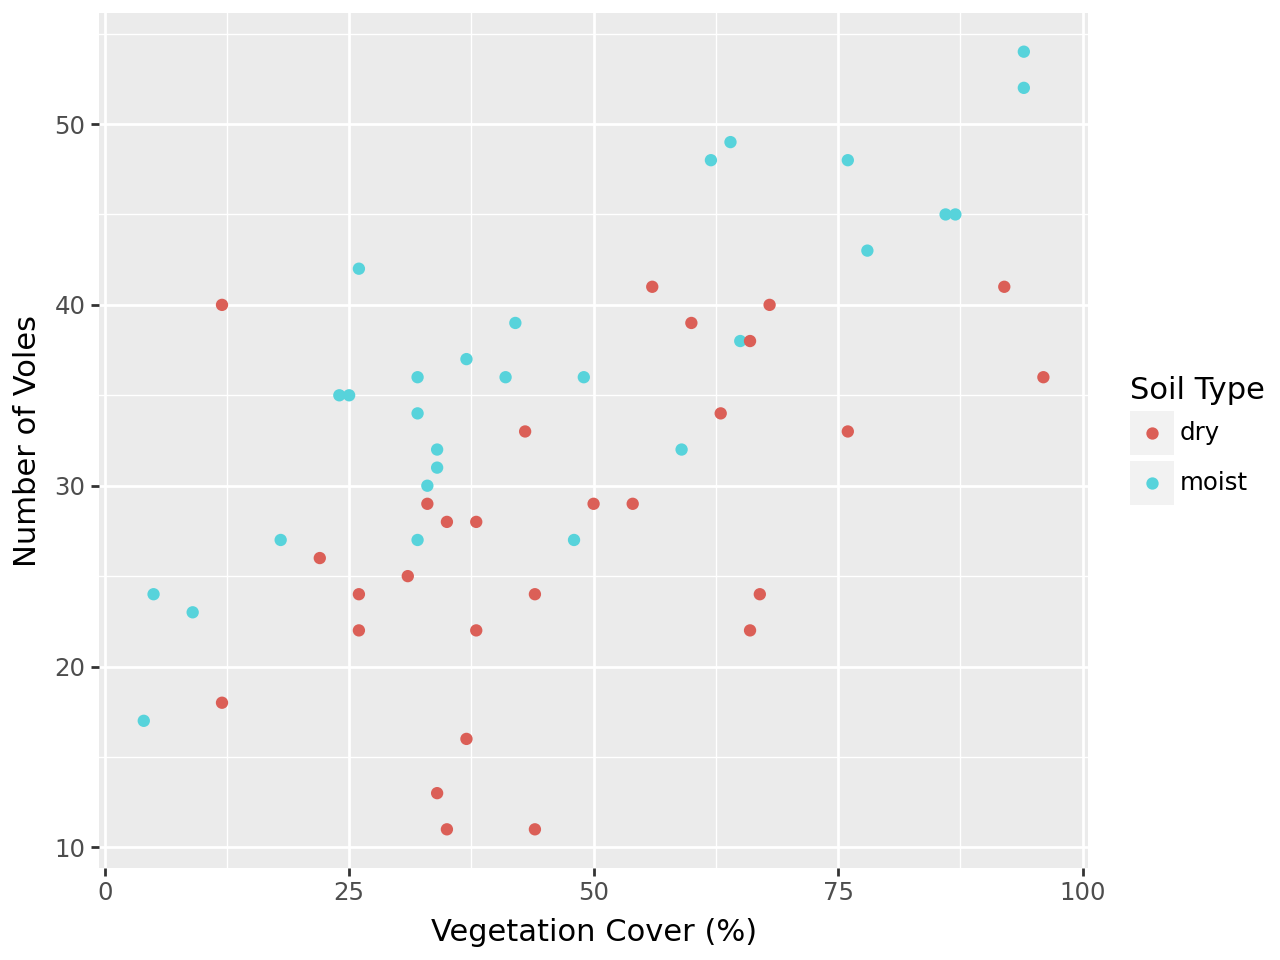

In [4]:
(
    ggplot(df_voles, aes(x='veg', y='voles', color='soil')) + 
    geom_point() +
    labs(x='Vegetation Cover (%)', y='Number of Voles', color='Soil Type')
)


## Modeling

In the cell below, model `voles` with `soil` and `veg` as predictors in a parallel slopes model. 

Here are the steps I would take:
1. Make a column transformer with `make_column_transformer` that transforms `soil` with `OneHotEncoder(drop="first")` and passes 'veg' through untransformed.
2. Create a pipeline with `make_pipeline` using the column transformer from above and `LinearRegression()` as my model. 
3. Get the `X` (training data) and `y` predictor from `df_voles`
4. Use the `.fit()` method for the pipeline to train the model with `X` and `y`. 

In [10]:
column_trans = make_column_transformer(
    (OneHotEncoder(drop='first'), ['soil']),
    remainder='passthrough'
)
pipe = make_pipeline(column_trans, LinearRegression())
X = df_voles[['soil', 'veg']]
y = df_voles['voles']
pipe.fit(X, y)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['soil'])])),
                ('linearregression', LinearRegression())])

Use the function below to get the parameter values for your model from above.

In [7]:
def get_regression_table(pipeline):
    terms=list(pipeline['columntransformer'].get_feature_names_out()) + ['intercept']
    mod = pipeline['linearregression']
    estimates = list(mod.coef_) + [mod.intercept_]
    data = dict(
        term=terms, 
        estimate=estimates,
    )
    return pd.DataFrame(data)


In [11]:
get_regression_table(pipe)


,term,estimate
0,onehotencoder__soil_moist,9.100298
1,remainder__veg,0.259069
2,intercept,15.464026


❓Would protecting a site with high vegetation cover be a more effective way to preserve the vole population than a site with low vegetation cover? Why?

(**Hint:** use your chart above to answer. It's also possible to leverage your regression parameters if you chose to model `voles` with a parallel slopes model.)

**Answer:**

Yes, protecting a site with high vegetation cover would be more effective for preserving the vole population compared to a site with low vegetation cover. This conclusion can be drawn from both the scatterplot and the regression coefficients.

Scatterplot: The scatterplot shows a clear positive relationship between vegetation cover and the number of voles. As the vegetation cover increases, the number of voles tends to increase as well, regardless of the soil type. This visual trend suggests that sites with higher vegetation cover are likely to support larger vole populations.

Regression coefficients: In the parallel slopes model, the coefficient for 'veg' (remainder__veg) is 0.259069, which is positive. This indicates that for each additional 1% increase in vegetation cover, the predicted number of voles increases by about 0.259, holding soil type constant. Therefore, increasing vegetation cover is associated with higher predicted vole counts.

❓Dry sites typically cost a lot less to purchase and maintain for conservation organizations. Thus, if a conservation organization decides to purchase a few dry sites, roughly what percent cover of vegetation do they need to maintain on these sites (at a minimum) to support a population of about 30 voles at the site?

(**Hint:** In your chart above, draw a line at voles = 30 using `geom_hline` and make a rough estimate for this answer...)

**Answer:**

To estimate the minimum vegetation cover needed for dry sites to support about 30 voles, we can use the scatterplot with a horizontal line at voles = 30.

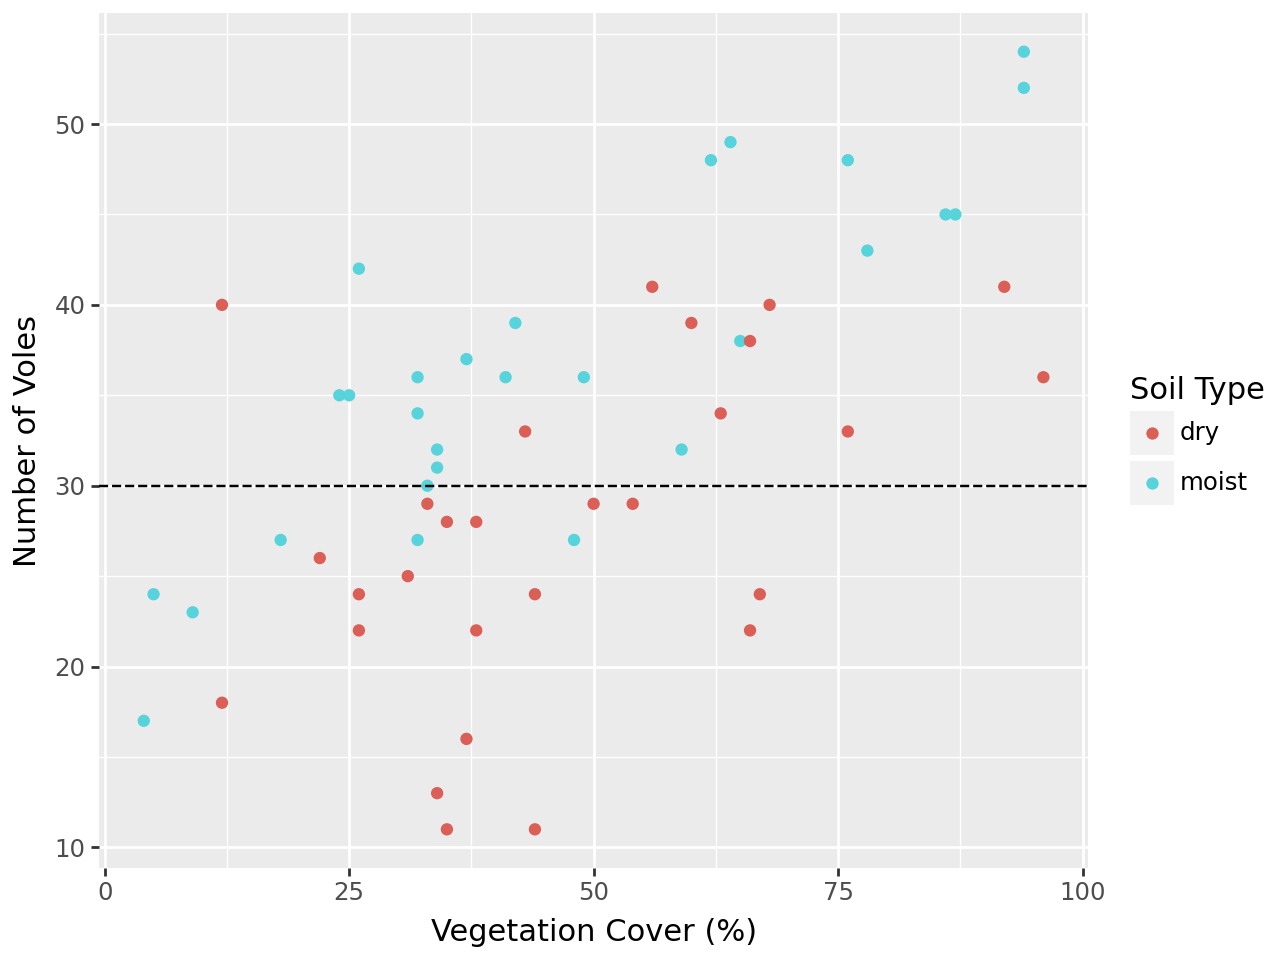

In [13]:
(
    ggplot(df_voles, aes(x='veg', y='voles', color='soil')) + 
    geom_point() +
    geom_hline(yintercept=30, linetype='dashed') +
    labs(x='Vegetation Cover (%)', y='Number of Voles', color='Soil Type')
)


By drawing a horizontal line at voles = 30 and looking at where it intersects with the cluster of "dry" points, we can estimate that dry sites would need a minimum of around 60-65% vegetation cover to support about 30 voles.

We can use the regression equation or the pipeline's predict method to estimate the vole population for a moist site with 40% vegetation cover.❓The Nature Conservancy is looking at purchasing a site for this species (in the same study area) that has moist soil and 40% vegetation cover. Using the regression equation what would you predict as the possible vole population the site might be able to support?

(**Hint:** Use `.predict(pd.DataFrame({"soil": ["moist"], "veg": [40]}))` with yout pipeline.)

**Answer:**

We can use the regression equation or the pipeline's predict method to estimate the vole population for a moist site with 40% vegetation cover.

In [12]:

pipe.predict(pd.DataFrame({"soil": ["moist"], "veg": [40]}))


array([34.92708151])

predicted_voles = 15.464026 + 9.100298 * (soil_moist) + 0.259069 * (veg_cover_pct)
predicted_voles = 15.464026 + 9.100298 * (1) + 0.259069 * (40)
               = 15.464026 + 9.100298 + 10.36276
               = 34.927084
Both methods predict approximately 35 voles for a moist site with 40% vegetation cover.

In summary, protecting sites with high vegetation cover is more effective for preserving vole populations, dry sites would need around 60-65% vegetation cover to support about 30 voles, and a moist site with 40% vegetation cover is predicted to support around 35 voles based on the regression model.